AUTHOR : HAMORA HADI
--
Named Entity Recognition using Long Short Term Memory (LSTMs)

In [2]:
%matplotlib inline

In [3]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
np.random.seed(0)
plt.style.use("ggplot")

In [4]:
import tensorflow as tf

Load the DataSet<br><br>
->geo = geographical entity<br>
->org = organization<br>
->per = person<br>
->gpe = geopolitical entity<br>
->tim = time indicator<br>
->art = artifact<br>
->eve = event<br>
->nat = natural phenomenon

In [6]:
data=pd.read_csv("C:/Users/User/Desktop/CreditCardApplication/ner_dataset.csv",encoding="latin1")

In [7]:
data=data.fillna(method="ffill")
data.head(20)

,Sentence #,Word,POS,Tag
0,Sentence: 1,Thousands,NNS,O
1,Sentence: 1,of,IN,O
2,Sentence: 1,demonstrators,NNS,O
3,Sentence: 1,have,VBP,O
4,Sentence: 1,marched,VBN,O
5,Sentence: 1,through,IN,O
6,Sentence: 1,London,NNP,B-geo
7,Sentence: 1,to,TO,O
8,Sentence: 1,protest,VB,O
9,Sentence: 1,the,DT,O


In [9]:
data.shape

(1048575, 4)

In [10]:
print("Unique words in corpus : ",data['Word'].nunique())

Unique words in corpus :  35178


In [11]:
print("Unique tags in corpus:", data['Tag'].nunique())

Unique tags in corpus: 17


In [12]:
words=list(set(data["Word"].values))
words.append("ENDPAD")
num_words=len(words)

In [14]:
tags = list(set(data["Tag"].values))

In [15]:
num_tags=len(tags)

<b>Retrieve Sentences and Corresponsing Tags</b>

In [16]:
class SentenceGetter(object):
    def __init__(self, data):
        self.n_sent = 1
        self.data = data
        self.empty = False
        agg_func = lambda s: [(w, p, t) for w, p, t in zip(
            s["Word"].values.tolist(),
            s["POS"].values.tolist(),
            s["Tag"].values.tolist()
        )]
        self.grouped = self.data.groupby("Sentence #").apply(agg_func)
        self.sentences = [s for s in self.grouped]
    
    def get_next(self):
        try:
            s = self.grouped["Sentence: {}".format(self.n_sent)]
            self.n_sent += 1
            return s
        except:
            return None

In [17]:
getter = SentenceGetter(data)

In [18]:
sentences=getter.sentences

In [19]:
sentences[0]

[('Thousands', 'NNS', 'O'),
 ('of', 'IN', 'O'),
 ('demonstrators', 'NNS', 'O'),
 ('have', 'VBP', 'O'),
 ('marched', 'VBN', 'O'),
 ('through', 'IN', 'O'),
 ('London', 'NNP', 'B-geo'),
 ('to', 'TO', 'O'),
 ('protest', 'VB', 'O'),
 ('the', 'DT', 'O'),
 ('war', 'NN', 'O'),
 ('in', 'IN', 'O'),
 ('Iraq', 'NNP', 'B-geo'),
 ('and', 'CC', 'O'),
 ('demand', 'VB', 'O'),
 ('the', 'DT', 'O'),
 ('withdrawal', 'NN', 'O'),
 ('of', 'IN', 'O'),
 ('British', 'JJ', 'B-gpe'),
 ('troops', 'NNS', 'O'),
 ('from', 'IN', 'O'),
 ('that', 'DT', 'O'),
 ('country', 'NN', 'O'),
 ('.', '.', 'O')]

In [20]:
sentences[1]

[('Iranian', 'JJ', 'B-gpe'),
 ('officials', 'NNS', 'O'),
 ('say', 'VBP', 'O'),
 ('they', 'PRP', 'O'),
 ('expect', 'VBP', 'O'),
 ('to', 'TO', 'O'),
 ('get', 'VB', 'O'),
 ('access', 'NN', 'O'),
 ('to', 'TO', 'O'),
 ('sealed', 'JJ', 'O'),
 ('sensitive', 'JJ', 'O'),
 ('parts', 'NNS', 'O'),
 ('of', 'IN', 'O'),
 ('the', 'DT', 'O'),
 ('plant', 'NN', 'O'),
 ('Wednesday', 'NNP', 'B-tim'),
 (',', ',', 'O'),
 ('after', 'IN', 'O'),
 ('an', 'DT', 'O'),
 ('IAEA', 'NNP', 'B-org'),
 ('surveillance', 'NN', 'O'),
 ('system', 'NN', 'O'),
 ('begins', 'VBZ', 'O'),
 ('functioning', 'VBG', 'O'),
 ('.', '.', 'O')]

<b>Define Mappings between Sentences and Tags</b>

In [21]:
word2idx = {w: i + 1 for i, w in enumerate(words)}
tag2idx = {t: i for i, t in enumerate(tags)}

In [22]:
word2idx

{'subterranean': 1,
 'promoter': 2,
 'Israeli-': 3,
 'establishes': 4,
 'uncovered': 5,
 'bigger': 6,
 'lease': 7,
 'centerpiece': 8,
 'DRC': 9,
 '9.4': 10,
 'Ashwell': 11,
 'editions': 12,
 '9.7': 13,
 'Wiseman': 14,
 'Eve': 15,
 'Hellenic': 16,
 'Oppose': 17,
 'commented': 18,
 'plucked': 19,
 'outcome': 20,
 'EEBC': 21,
 'time-stamped': 22,
 'archaeologists': 23,
 'Katsina': 24,
 'mid-17th': 25,
 'disclosure': 26,
 'Patat': 27,
 'commandoes': 28,
 'employs': 29,
 '13-year': 30,
 'devastating': 31,
 'entities': 32,
 'hemp': 33,
 'Kuenast': 34,
 'delicate': 35,
 'Ibaraki': 36,
 'Shiekh': 37,
 'magnet': 38,
 'stirred': 39,
 'Blagojevic': 40,
 'state-of-the-nation': 41,
 'bridged': 42,
 '423-1': 43,
 'rebels': 44,
 'southwestern': 45,
 'listing': 46,
 'Tallinn': 47,
 'Mokhine': 48,
 'Thermo': 49,
 'Significant': 50,
 'waterways': 51,
 'Sam': 52,
 'Kehla': 53,
 'vortex': 54,
 'predictor': 55,
 'place': 56,
 'Radak': 57,
 'forecasters': 58,
 'touring': 59,
 'Gabcikovo': 60,
 'Girona': 61,

Padding Input Sentences and Creating Train/Test Splits

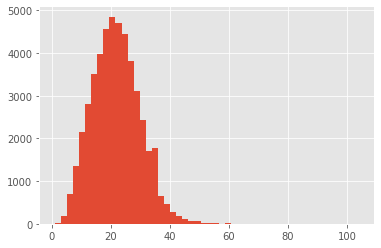

In [23]:
plt.hist([len(s) for s in sentences], bins=50)
plt.show()

In [24]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

max_len = 50

X = [[word2idx[w[0]] for w in s] for s in sentences]
X = pad_sequences(maxlen=max_len, sequences=X, padding="post", value=num_words-1)

y = [[tag2idx[w[2]] for w in s] for s in sentences]
y = pad_sequences(maxlen=max_len, sequences=y, padding="post", value=tag2idx["O"])

In [25]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

<b>Build and Compile a Bidirectional LSTM Model</b>

In [26]:
from tensorflow.keras import Model, Input
from tensorflow.keras.layers import LSTM, Embedding, Dense
from tensorflow.keras.layers import TimeDistributed, SpatialDropout1D, Bidirectional

In [27]:
input_word = Input(shape=(max_len,))
model = Embedding(input_dim=num_words, output_dim=50, input_length=max_len)(input_word)
model = SpatialDropout1D(0.1)(model)
model = Bidirectional(LSTM(units=100, return_sequences=True, recurrent_dropout=0.1))(model)
out = TimeDistributed(Dense(num_tags, activation="softmax"))(model)
model = Model(input_word, out)
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 50)]              0         
_________________________________________________________________
embedding (Embedding)        (None, 50, 50)            1758950   
_________________________________________________________________
spatial_dropout1d (SpatialDr (None, 50, 50)            0         
_________________________________________________________________
bidirectional (Bidirectional (None, 50, 200)           120800    
_________________________________________________________________
time_distributed (TimeDistri (None, 50, 17)            3417      
Total params: 1,883,167
Trainable params: 1,883,167
Non-trainable params: 0
_________________________________________________________________


In [29]:
model.compile(
    optimizer="adam",
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

<b>TRAIN!</b>

In [30]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

In [31]:
%%time

UsageError: %%time is a cell magic, but the cell body is empty. Did you mean the line magic %time (single %)?


In [32]:
chkpt = ModelCheckpoint(
    "model_weights.h5", 
    monitor='val_loss',
    verbose=1, 
    save_best_only=True, 
    save_weights_only=True, 
    mode='min'
)

In [33]:
early_stopping = EarlyStopping(
    monitor='val_accuracy', 
    min_delta=0, 
    patience=1, 
    verbose=0, 
    mode='max', 
    baseline=None, 
    restore_best_weights=False
)

In [34]:
callbacks = [chkpt, early_stopping]

In [35]:
history = model.fit(
    x=x_train,
    y=y_train,
    validation_data=(x_test,y_test),
    batch_size=32, 
    epochs=3,
    callbacks=callbacks,
    verbose=1
)

Epoch 1/3
1199/1199 [==============================] - ETA: 0s - loss: 0.1788 - accuracy: 0.9589
Epoch 00001: val_loss improved from inf to 0.06454, saving model to model_weights.h5
1199/1199 [==============================] - 104s 87ms/step - loss: 0.1788 - accuracy: 0.9589 - val_loss: 0.0645 - val_accuracy: 0.9817
Epoch 2/3
1199/1199 [==============================] - ETA: 0s - loss: 0.0498 - accuracy: 0.9852
Epoch 00002: val_loss improved from 0.06454 to 0.05070, saving model to model_weights.h5
1199/1199 [==============================] - 108s 90ms/step - loss: 0.0498 - accuracy: 0.9852 - val_loss: 0.0507 - val_accuracy: 0.9850
Epoch 3/3
1199/1199 [==============================] - ETA: 0s - loss: 0.0366 - accuracy: 0.9888
Epoch 00003: val_loss improved from 0.05070 to 0.04863, saving model to model_weights.h5
1199/1199 [==============================] - 108s 90ms/step - loss: 0.0366 - accuracy: 0.9888 - val_loss: 0.0486 - val_accuracy: 0.9852


Evaluate the model

In [36]:
model.evaluate(x_test,y_test)

300/300 [==============================] - 3s 9ms/step - loss: 0.0486 - accuracy: 0.9852


[0.04863011837005615, 0.9852335453033447]

In [37]:
i = np.random.randint(1, x_test.shape[0]) #659
p = model.predict(np.array([x_test[i]]))
p = np.argmax(p, axis=-1)
y_true = y_test[i]
print("{:15}{:5}\t {}\n".format("Word", "True", "Pred"))
print("-" *30)
for w, true, pred in zip(x_test[i], y_true, p[0]):
    print("{:15}{}\t{}".format(words[w-1], tags[true], tags[pred]))

Word           True 	 Pred

------------------------------
In             O	O
July           B-tim	B-tim
,              O	O
an             O	O
explosion      O	O
at             O	O
a              O	O
suspected      O	O
Hezbollah      B-org	B-org
arms           O	O
depot          O	O
in             O	O
southern       B-geo	O
Lebanon        I-geo	B-geo
near           O	O
the            O	O
Israeli        B-gpe	B-gpe
border         O	O
raised         O	O
concerns       O	O
about          O	O
the            O	O
group          O	O
's             O	O
weapons        O	O
caches         O	O
.              O	O
Foy            O	O
Foy            O	O
Foy            O	O
Foy            O	O
Foy            O	O
Foy            O	O
Foy            O	O
Foy            O	O
Foy            O	O
Foy            O	O
Foy            O	O
Foy            O	O
Foy            O	O
Foy            O	O
Foy            O	O
Foy            O	O
Foy            O	O
Foy            O	O
Foy            O	O
Foy            O	O
Foy         